# Single Integral Comparison

*David Thomas 2017/03/29*

Abstract

# Setup

Inference and data.

# Methods

Below we discuss four different techniques for computing the likelihood. The code corresponding to each can be found in bigmali.likelihood.

#### Numerical Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) &= \iint\ dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \sum_{M=min(MP)}^{max(MP)}\sum_{L = min(L_{obs})}^{max(L_{obs})}\ \Delta_M\Delta_L\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
\end{align*}


#### Simple Monte Carlo Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs},z) &= \iint dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \frac{1}{N_s}\sum_{M \sim\ P(M|z)}\sum_{L \sim\ P(L|M, \alpha, S, z)} P(L_{obs}|L, \sigma_{obs})\\
\end{align*}

#### Importance Sampling Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs},z,c) &= \iint dLdM \frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}{Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}\\
&= \frac{1}{N_s}\sum_{(M,L) \sim\ (Q(M|L,\alpha, S, z, c), Q(L|L_{obs}, \sigma_{obs}))}\frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)}{Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}\\
\end{align*}


#### Laplace Approximation Integration

Let 
$$f(M,L) = \ln P(L_{obs}|L, \sigma_{obs}) + \ln P(L|M, \alpha, S, z) + \ln P(M|z)$$

Then we use a Quasi-Newton method to solve 

$$\ln M_{opt},\ln L_{opt}, H_{ln\ opt}^{-1} = \text{argmin}_{\ln M,\ln L} -\left[f(M,L)\right]$$

where we optimize over logarithmic mass and luminosity because otherwise the numerical disparity between mass and luminosity leads to an inaccurate diagonal hessian. Then by the chain rule we have 

$$-\frac{\partial^2 f}{\partial M \partial L} = -\frac{\partial^2 f}{\partial \ln M \partial \ln L} \frac{\partial \ln M}{\partial M} \frac{\partial \ln L}{\partial L} = -\frac{1}{ML}\frac{\partial^2 f}{\partial \ln M \partial \ln L}$$

Hence our desired Hessian is

$$H_{opt} = (H_{ln\ opt}^{-1})^{-1} \odot \begin{pmatrix}M_{opt}^{-2} & M_{opt}^{-1}L_{opt}^{-1}\\ M_{opt}^{-1}L_{opt}^{-1} & L_{opt}^{-2} \end{pmatrix}$$

where $\odot$ is elementwise multiplication. Then we can approximate the likelihood as 

$$\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) = \exp(f(M_{opt}, L_{opt}))\sqrt{\frac{(2\pi)^2}{\det(H_{opt})}}$$

To test this approximation we can also see how well $f(M,L)$ is approximated by its Gaussian approximation

$$f(M_{opt}, L_{opt})\exp(\frac{-1}{2}((M,L) - (M_{opt}, L_{opt}))^T H((M,L) - (M_{opt}, L_{opt}))$$


In [669]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
from scipy.stats import lognorm
from time import time
import seaborn.apionly as sns
from scipy.optimize import minimize
from math import sqrt
from time import time
rc('text', usetex=True)
from matplotlib.patches import Ellipse

data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')

prior = TinkerPrior(Grid())

def p1(lobs, lum, sigma):
    return fast_lognormal(lum, sigma, lobs)

def p2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_lognormal(mu_lum, S, lum)
    
def p3(mass, z):
    return prior.fetch(z).pdf(mass)

def q1(lum, lobs, sigma):
    return fast_lognormal(lobs, sigma, lum)
    
def q2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_lognormal(mu_mass, S, mass)

def logp1(lobs, lum, sigma):
    return fast_log_lognormal(lum, sigma, lobs)

def logp2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_log_lognormal(mu_lum, S, lum)

def logp3(mass, z):
    return prior.fetch(z).logpdf(mass)


def midpoints(arr):
    n = len(arr)-1
    ret = np.zeros(n)
    for i in xrange(n):
        ret[i] = (arr[i+1] + arr[i]) / 2.
    return ret

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

def fast_log_lognormal(mu, sigma, x):
    return  -np.log(x * sigma * np.sqrt(2 * np.pi)) - 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2

def log10(arr):
    return np.log(arr) / np.log(10)

def toColor(weights, integrands):
    #first we log-normalize to interval [0,1]
    lw = np.log(weights + 1e-30)
    li = np.log(integrands + 1e-30)
    nlw = (lw - lw.min()) / (lw.max() - lw.min())
    nli = (li - li.min()) / (li.max() - li.min())
    colors = np.zeros((len(weights), 4))
    for i in xrange(len(weights)):
        colors[i,:] = cm.coolwarm(255 * nlw[i], nli[i])
    return colors

def numerical_integration(a1, a2, a3, a4, S, nsamples=10**3):
    masses = midpoints(prior.fetch(true_z).mass[1:])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

def simple_monte_carlo_integration(a1, a2, a3, a4, S, nsamples=10**6):
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    return np.sum(p1(true_lum_obs, lums, sigma)) / (nsamples)

def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    rev_S = 5.6578015811698101 * S
    lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    integral = np.sum((p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
            len(lums)
    return integral

def neg_log_integrand(a1, a2, a3, a4, S):
    def func(prms):
        mass, lum = np.exp(prms)
        return - logp1(true_lum_obs, lum, sigma) \
            - logp2(lum, mass, a1, a2, a3, a4, S, true_z) \
            - logp3(mass, true_z)
    return func

def laplace_approximation(a1, a2, a3, a4, S):
    x0 = [np.log(10**11), np.log(10**4.0)]
    func = neg_log_integrand(a1, a2, a3, a4, S)
    ans = minimize(func, x0, method='BFGS')
    h = np.linalg.inv(ans['hess_inv'])
    h[0,0] = h[0,0] * (1/np.exp(ans['x'][0])) ** 2
    h[1,0] = h[1,0] * (1/np.exp(ans['x'][0])) * (1/np.exp(ans['x'][1]))
    h[0,1] = h[1,0]
    h[1,1] = h[1,1] * (1/np.exp(ans['x'][1])) ** 2
    return np.exp(-func(ans['x'])) * sqrt((2 * np.pi) ** 2/ np.linalg.det(h))

def laplace_approximation_samples(a1, a2, a3, a4, S):
    x0 = [np.log(10**11), np.log(10**4.0)]
    path = [x0]
    def save(prms):
        path.append(prms)
    ans = minimize(neg_log_integrand(a1, a2, a3, a4, S), x0, method='BFGS', callback=save)
    path_t = np.exp(np.stack(path, axis=0).transpose())
    return path_t[0,:], path_t[1,:], ans['hess_inv']

def numerical_integration_grid(a1, a2, a3, a4, S):
    nsamples = 100
    masses = midpoints(prior.fetch(true_z).mass[1:-1])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:-1])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    sigma = 0.05
    integral = 0
    ans = np.zeros((len(lums)*len(masses),3))
    count = 0
    for i, lum in enumerate(lums):
        for j, mass in enumerate(masses):
            ans[count,0] = lum
            ans[count,1] = mass
            ans[count,2] = np.sum(delta_masses[j] * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, mass, a1, a2, a3, a4, S, true_z) * p3(mass, true_z))
            count += 1
    return ans

def simple_monte_carlo_integration_samples(a1, a2, a3, a4, S, nsamples=10**3):
    sigma = 0.05
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    weights = p1(true_lum_obs, lums, sigma)
    integrands = p1(true_lum_obs, lums, sigma) * p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)
    return masses, lums, weights, integrands

def importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**3):
    rev_S = 5.6578015811698101 * S
    lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    weights = (p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))
    integrands = p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)
    return masses, lums, weights, integrands

a1,a2,a3,a4,S = get()
sigma = 0.05

def fix_point(idx):
    true_mass = data.mass.ix[idx]
    true_z = data.z.ix[idx]
    true_lum = data.lum.ix[idx]
    true_lum_obs = data.lum_obs.ix[idx]
    true_lum_obs_collection = data.lum_obs

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]
    
def make_plot_panel():
    
    massv = log10(data.mass.as_matrix())
    lumobsv = log10(data.lum_obs.as_matrix())
    zv = data.z.as_matrix()
    ind = (zv > true_z * 0.9) & (zv < true_z * 1.1) & (massv > log10(true_mass)*0.9) & (massv < log10(true_mass)*1.1)
    mean = np.percentile(lumobsv[ind], 50)
    hi = np.percentile(lumobsv[ind], 68) - mean
    lo = mean - np.percentile(lumobsv[ind], 32)
    yerr=[[lo],[hi]]
    m, l, w, i = importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**3)
    vmax = w.max()
    grid = numerical_integration_grid(a1,a2,a3,a4,S)
    step = 1
    epsilon = 1e-20
    gridv = np.maximum(grid[::step,2], epsilon)
    vmin = gridv.min()
    
    plt.subplot(2,2,1)
    y = log10(grid[::step,0])
    x = log10(grid[::step,1])
    ylim = [y.min(), y.max()]
    xlim = [x.min(), x.max()]
    scat = plt.scatter(x,y, marker='s', s=40, alpha=0.8, c=gridv, norm=colors.LogNorm(), cmap='coolwarm', lw=0, vmin=vmin, vmax=vmax);
    plt.errorbar(log10(true_mass), mean, yerr=yerr, fmt='-x', color='k')
    plt.scatter(log10(true_mass), log10(true_lum_obs), color='k')
    plt.gcf().set_size_inches((6,6))
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.gcf().colorbar(scat)
    plt.title('Numerical Integration Weights')
    plt.xlabel('Mass ($\log_{10}\ M_{\odot}$)')
    plt.ylabel('Luminosity ($\log_{10}\ L_{\odot} / h^2$)')
    
    plt.subplot(2,2,2)
    m, l, w, i = simple_monte_carlo_integration_samples(a1, a2, a3, a4, S, nsamples=10**3)
    scat = plt.scatter(log10(m), log10(l), s=20, alpha=0.8, c=w, norm=colors.LogNorm(), cmap='coolwarm', lw=0, vmin=vmin, vmax=vmax);
    plt.errorbar(log10(true_mass), mean, yerr=yerr, fmt='-x', color='k')
    plt.scatter(log10(true_mass), log10(true_lum_obs), color='k')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.gcf().colorbar(scat)
    plt.title('Simple Monte Carlo Weights')
    plt.xlabel('Mass ($\log_{10}\ M_{\odot}$)')
    plt.ylabel('Luminosity ($\log_{10}\ L_{\odot} / h^2$)')
    
    plt.subplot(2,2,3)
    m, l, w, i = importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**3)
    scat = plt.scatter(log10(m), log10(l), s=20, alpha=0.8, c=w, norm=colors.LogNorm(), cmap='coolwarm', lw=0, vmin=vmin, vmax=vmax)
    plt.errorbar(log10(true_mass), mean, yerr=yerr, fmt='-x', color='k')
    plt.scatter(log10(true_mass), log10(true_lum_obs), color='k')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.gcf().colorbar(scat)
    plt.title('Importance Sampling Weights')
    plt.xlabel('Mass ($\log_{10}\ M_{\odot}$)')
    plt.ylabel('Luminosity ($\log_{10}\ L_{\odot} / h^2$)')
    
    plt.subplot(2,2,4)
    m, l, cov = laplace_approximation_samples(a1, a2, a3, a4, S)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    nstd=1
    width, height = 1 * nstd * np.sqrt(vals)
    ellip1 = Ellipse(xy=(log10(m[-1]), log10(l[-1])), width=width, height=height, angle=theta, color='gray', alpha=0.6)
    width, height = 2 * nstd * np.sqrt(vals)
    ellip2 = Ellipse(xy=(log10(m[-1]), log10(l[-1])), width=width, height=height, angle=theta, color='gray', alpha=0.2)
    plt.gca().add_artist(ellip1)
    plt.gca().add_artist(ellip2)
    
    w = p1(true_lum_obs, l, sigma) * p2(l, m, a1, a2, a3, a4, S, true_z) * p3(m, true_z)
    scat = plt.scatter(log10(m), log10(l),  s=20, alpha=0.8, c=w, norm=colors.LogNorm(), cmap='coolwarm', lw=0)
    plt.plot(log10(m), log10(l), linestyle='--', color='gray')
    plt.errorbar(log10(true_mass), mean, yerr=yerr, fmt='-x', color='k')
    plt.scatter(log10(true_mass), log10(true_lum_obs), color='k')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.gcf().colorbar(scat)
    plt.title('Laplace Approximation Path')
    plt.xlabel('Mass ($\log_{10}\ M_{\odot}$)')
    plt.ylabel('Luminosity ($\log_{10}\ L_{\odot} / h^2$)')
    
    plt.gcf().set_size_inches((8,8))
    plt.tight_layout()

In [614]:
m, l, _ = laplace_approximation_samples(a1, a2, a3, a4, S)
w = p1(true_lum_obs, l, sigma) * p2(l, m, a1, a2, a3, a4, S, true_z) * p3(m, true_z)

# Characterizing Approaches over Four Distinct Points

### Selecting Points
We start by isolating four points in different regions of the M-L plane that we will use in testing below.

In [3]:
dat = np.array([np.arange(len(data.mass)), log10(data.mass), log10(data.lum)]).transpose()
datr = np.random.permutation(dat)

In [4]:
idx = (datr[:,1] < 11.2) & (datr[:,1] > 11.0) & (datr[:,2] > 3.8) & (datr[:,2] < 4.0)
datr[idx]

array([[  5.19130000e+04,   1.11995544e+01,   3.90565383e+00],
       [  7.40620000e+04,   1.11673694e+01,   3.93304135e+00],
       [  7.94170000e+04,   1.10103403e+01,   3.97087604e+00],
       ..., 
       [  2.49600000e+03,   1.10582255e+01,   3.90617323e+00],
       [  6.76990000e+04,   1.11346137e+01,   3.90150384e+00],
       [  8.04710000e+04,   1.10746143e+01,   3.81411623e+00]])

In [567]:
datr[(datr[:,1] < 10.2)]

array([[  8.47250000e+04,   1.00991820e+01,   3.36969141e+00],
       [  8.01300000e+03,   1.00991820e+01,   3.27353014e+00],
       [  1.01009000e+05,   1.01783649e+01,   3.48085557e+00],
       ..., 
       [  8.02120000e+04,   1.01405767e+01,   3.35887531e+00],
       [  1.04489000e+05,   1.01203723e+01,   3.14971294e+00],
       [  1.08631000e+05,   1.01960925e+01,   3.31434589e+00]])

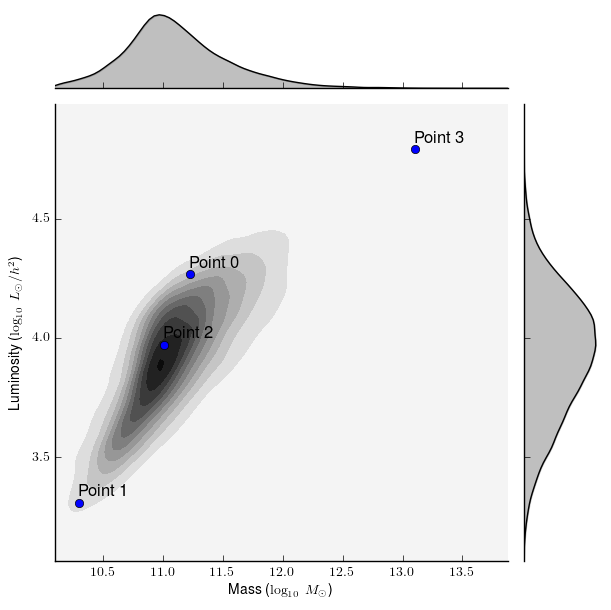

In [668]:
inds = [115916, 103133, 79417, 13008]

ax = sns.jointplot(x=datr[:30000,1], y=datr[:30000,2], kind="kde", color='black');
# ax.ax_joint.scatter(dat[:,1][:1000], dat[:,2][:1000], alpha=0.4, marker='x', s=10, lw=1, c='gray')
for i,ind in enumerate(inds):
    ax.ax_joint.plot(dat[ind,1], dat[ind,2], marker='o', color='blue')
    ax.ax_joint.text(dat[ind,1], dat[ind,2]+0.03, "Point %d" % i, ha ='left', fontsize = 12, color='black')
ax.ax_joint.legend_.remove()
ax.ax_joint.set_ylabel('Luminosity ($\log_{10}\ L_{\odot} / h^2$)')
ax.ax_joint.set_xlabel('Mass ($\log_{10}\ M_{\odot}$)')
xlim = (datr[:30000, 1].min(), datr[:30000, 1].max())
ylim = (datr[:30000, 2].min(), datr[:30000, 2].max())
ax.ax_joint.set_xlim(xlim)
ax.ax_joint.set_ylim(ylim);

### Point 0

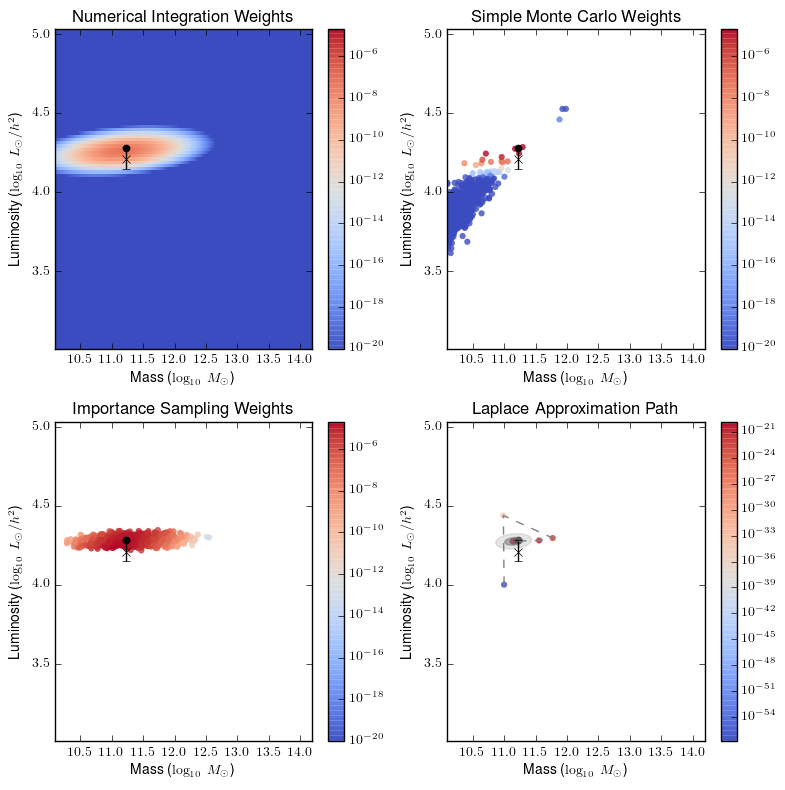

In [670]:
idx = 115916
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

Note to Phil: I want to add the BFGS path for laplace approximation to this panel.

In [671]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 6.40358058377e-06
simple monte carlo: 8.57179497702e-07
importance sampling: 6.39959705909e-06
laplace approximation: 3.68701955823e-06


### Point 1

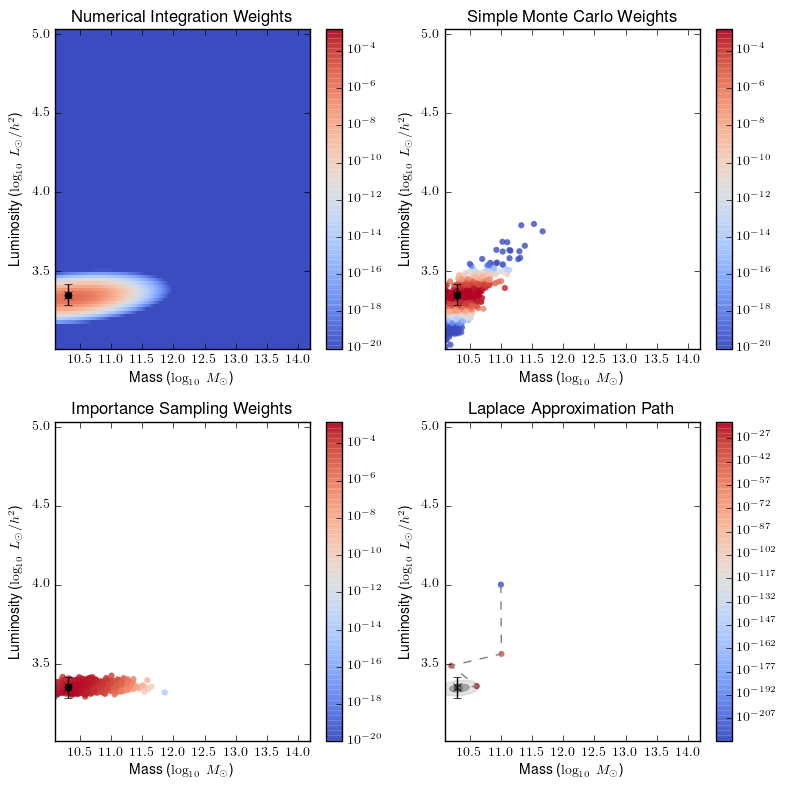

In [672]:
idx = 103133
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

In [673]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 0.000487808661776
simple monte carlo: 0.000487547191603
importance sampling: 0.000487206370881
laplace approximation: 0.000316487709918


### Point 2

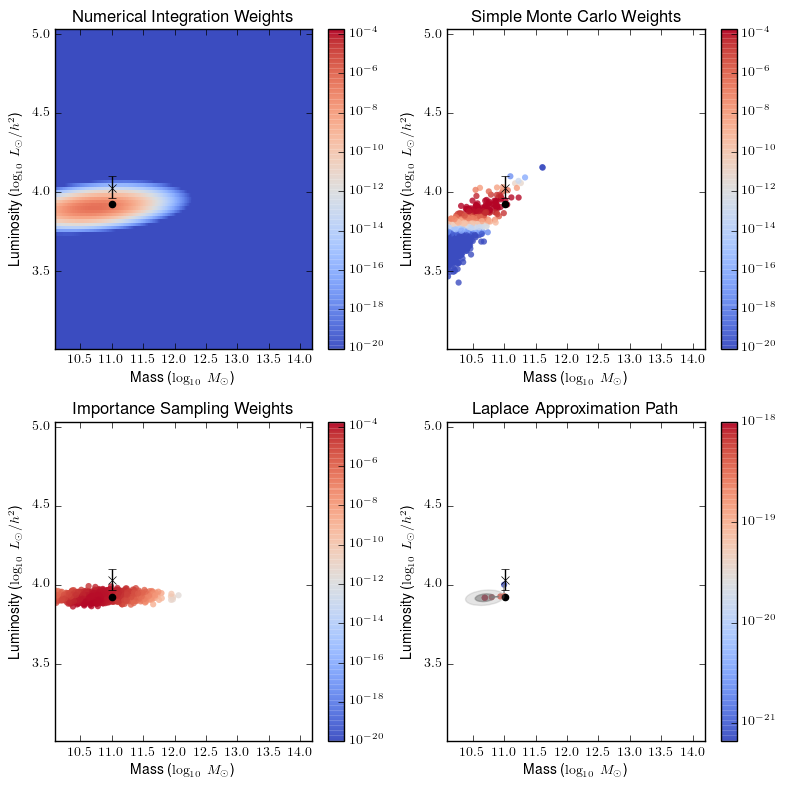

In [674]:
idx = 79417
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

In [675]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 6.27613065943e-05
simple monte carlo: 2.82394491619e-05
importance sampling: 6.29604927168e-05
laplace approximation: 3.80374065466e-05


### Point 3

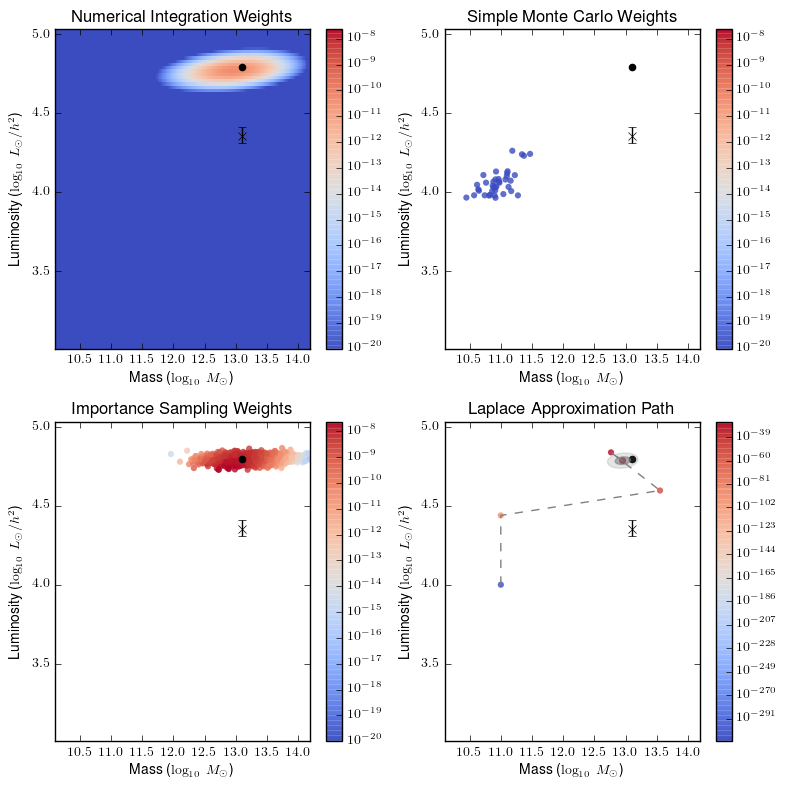

In [676]:
idx = 13008
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

In [677]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 5.57536196939e-09
simple monte carlo: 3.49945536295e-53
importance sampling: 5.57880154767e-09
laplace approximation: 2.89024212204e-09


# Convergence

In [679]:
idx = 0
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs

In [452]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 1.16445343689e-05
simple monte carlo: 1.84448649267e-06
importance sampling: 1.16224508801e-05
laplace approximation: 6.99930275849e-06


In [689]:
n = 10
vals = np.zeros((n, 4))
timevals = np.zeros((n, 4))
logspace = np.logspace(1, 5, n)
for i, nsamples in enumerate(logspace):
    nsamples = int(nsamples)
    start = time()
    vals[i][0] = numerical_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time()
    timevals[i][0] = end - start
    
    start = time()
    vals[i][1] = simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time()
    timevals[i][1] = end - start
    
    start = time()
    vals[i][2] = importance_sampling_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time()
    timevals[i][2] = end - start
    
    start = time()
    vals[i][3] = laplace_approximation(a1,a2,a3,a4,S)
    end = time()
    timevals[i][3] = end - start

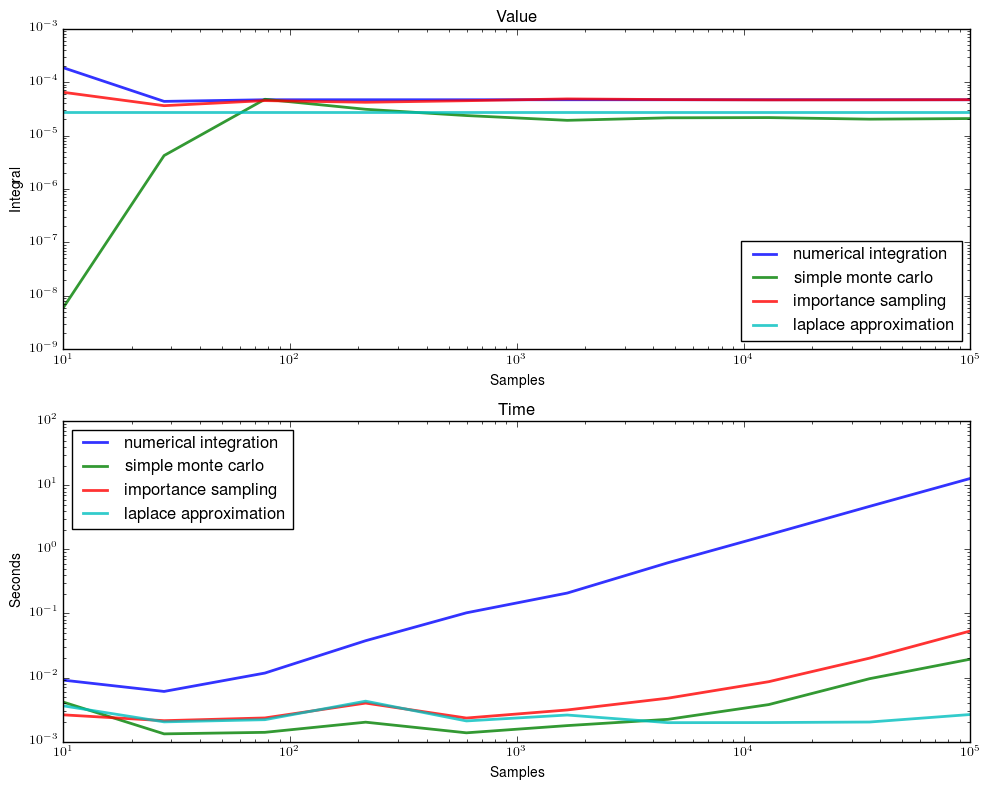

In [690]:
plt.subplot(211)
plt.plot(logspace, vals[:,0], label='numerical integration', linewidth=2, alpha=0.8)
plt.plot(logspace, vals[:,1], label='simple monte carlo', linewidth=2, alpha=0.8)
plt.plot(logspace, vals[:,2], label='importance sampling', linewidth=2, alpha=0.8)
plt.plot(logspace, vals[:,3], label='laplace approximation', linewidth=2, alpha=0.8)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Value')
plt.xlabel('Samples')
plt.ylabel('Integral')
plt.xlim([10,10**5])
plt.legend(loc=4)

plt.subplot(212)
plt.plot(logspace, timevals[:,0], label='numerical integration', linewidth=2, alpha=0.8)
plt.plot(logspace, timevals[:,1], label='simple monte carlo', linewidth=2, alpha=0.8)
plt.plot(logspace, timevals[:,2], label='importance sampling', linewidth=2, alpha=0.8)
plt.plot(logspace, timevals[:,3], label='laplace approximation', linewidth=2, alpha=0.8)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.legend(loc=2)
plt.xlim([10,10**5])

plt.gcf().set_size_inches(10,8)
plt.tight_layout();

In [685]:
space = np.logspace(1,5,10)
samples = 100
rel_error = np.zeros((samples, len(space)))
indices=np.random.permutation(range(len(data.mass)))[:samples]
for i, idx in enumerate(indices):
    true_mass = data.mass.ix[idx]
    true_z = data.z.ix[idx]
    true_lum = data.lum.ix[idx]
    true_lum_obs = data.lum_obs.ix[idx]
    true_lum_obs_collection = data.lum_obs
    ans = importance_sampling_integration(a1,a2,a3,a4,S, nsamples=10**5)
    for j,t in enumerate(space):
        s = int(t)
        rel_error[i,j] = (abs(importance_sampling_integration(a1,a2,a3,a4,S, nsamples=s) - ans) / ans) 

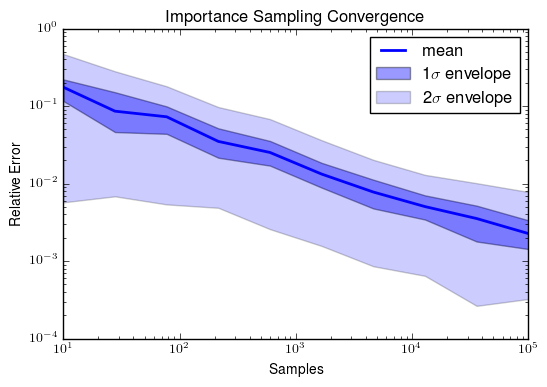

In [687]:
shi = map(lambda x: np.percentile(x, 95), rel_error.transpose())
hi = map(lambda x: np.percentile(x, 68), rel_error.transpose())
mean = map(lambda x: np.percentile(x, 50), rel_error.transpose())
lo = map(lambda x: np.percentile(x, 32), rel_error.transpose())
slo = map(lambda x: np.percentile(x, 5), rel_error.transpose())

plt.plot(space, mean, linewidth=2, label='mean')
plt.fill_between(space, lo, hi, alpha=0.4, label='1$\sigma$ envelope')
plt.fill_between(space, slo, shi, alpha=0.2, label='2$\sigma$ envelope')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.title('Importance Sampling Precision')
plt.ylabel('Relative Error')
plt.xlabel('Samples')
plt.legend();

In [600]:
space = np.logspace(1,5,20)
samples = 1
rel_error = np.zeros((samples, len(space)))
indices=np.random.permutation(range(len(data.mass)))[:samples]
for i, idx in enumerate(indices):
    true_mass = data.mass.ix[idx]
    true_z = data.z.ix[idx]
    true_lum = data.lum.ix[idx]
    true_lum_obs = data.lum_obs.ix[idx]
    true_lum_obs_collection = data.lum_obs
    ans = numerical_integration(a1,a2,a3,a4,S, nsamples=10**5)
    for j,t in enumerate(space):
        s = int(t)
        rel_error[i,j] = (abs(numerical_integration(a1,a2,a3,a4,S, nsamples=s) - ans) / ans) 

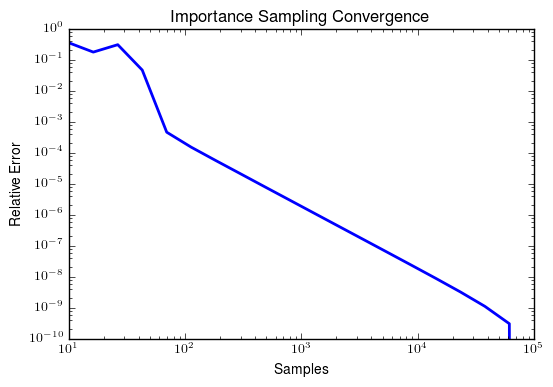

In [602]:
# shi = map(lambda x: np.percentile(x, 95), rel_error.transpose())
# hi = map(lambda x: np.percentile(x, 68), rel_error.transpose())
mean = map(lambda x: np.percentile(x, 50), rel_error.transpose())
# lo = map(lambda x: np.percentile(x, 32), rel_error.transpose())
# slo = map(lambda x: np.percentile(x, 5), rel_error.transpose())

plt.plot(space, mean, linewidth=2)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.title('Importance Sampling Convergence')
plt.ylabel('Relative Error')
plt.xlabel('Samples')

TODO: confirm over different seeds.

# Posterior Comparison

Leaving out SMC because of poor convergence.

In [575]:
idx = 0
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs

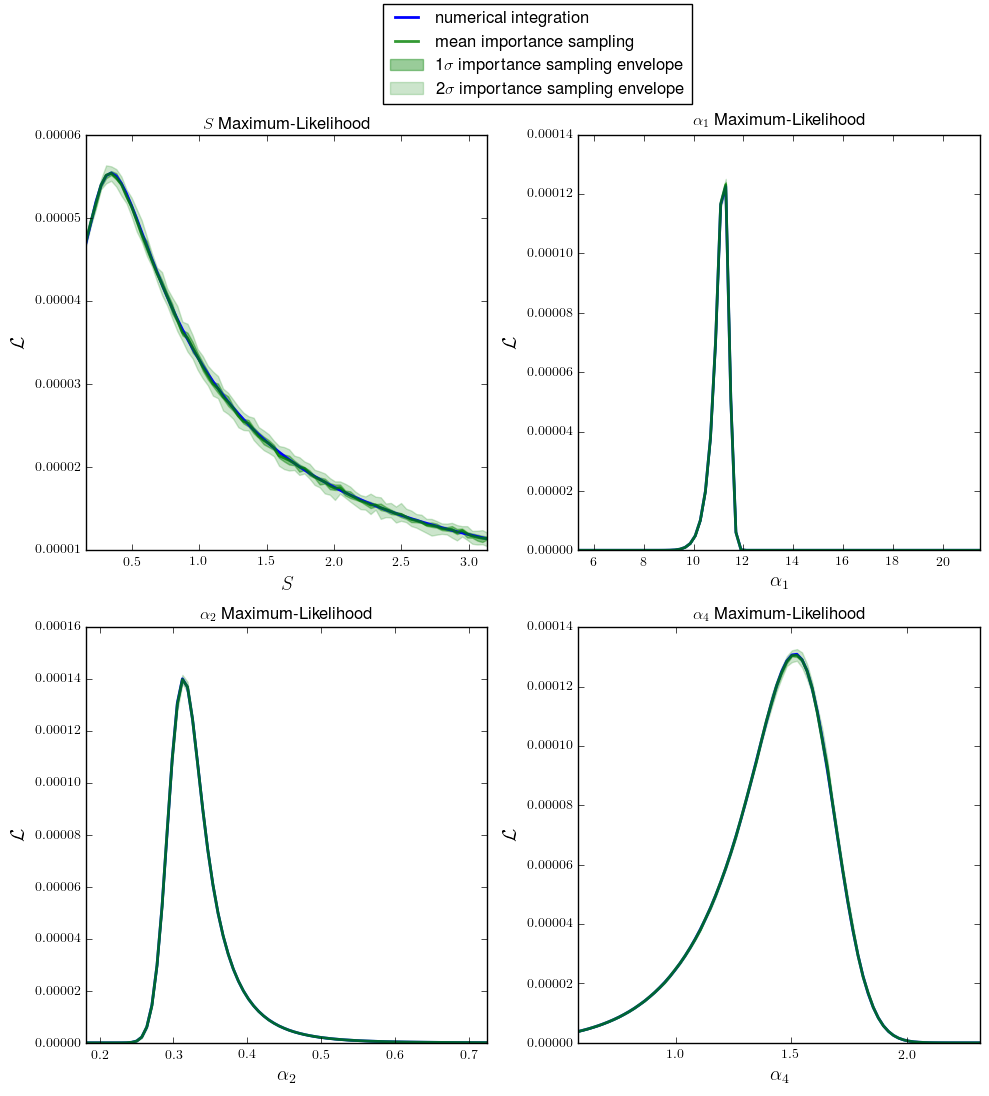

In [694]:
samps = 20
ticks = 80

plt.subplot(2,2,1)
space = S * np.linspace(1,20, ticks)
vals = np.zeros((len(space), samps))
ni = []
for i,S_test in enumerate(space):
    ni.append(numerical_integration(a1,a2,a3,a4,S_test,nsamples=100))
    for j in xrange(samps):
        vals[i,j] = importance_sampling_integration(a1,a2,a3,a4,S_test,nsamples=10**4)
mean = map(lambda x: np.mean(x), vals)
hi = map(lambda x: np.percentile(x,68), vals)
lo = map(lambda x: np.percentile(x, 32), vals)
shi = map(lambda x: np.percentile(x, 95), vals)
slo = map(lambda x: np.percentile(x, 5), vals)
plt.plot(space, ni, linewidth=2, color='blue')
plt.plot(space, mean, alpha=0.8, linewidth=2, color='green')
plt.fill_between(space, lo, hi, alpha=0.4, color='green')
plt.fill_between(space, slo, shi, alpha=0.2, color='green')
plt.title('$S$ Maximum-Likelihood')
plt.xlabel(r'$S$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,2)
space = a1 * np.linspace(0.5,2, ticks)
ni = []
vals = np.zeros((len(space), samps))
for i,a1_test in enumerate(space):
    ni.append(numerical_integration(a1_test,a2,a3,a4,S,nsamples=100))
    for j in xrange(samps):
        vals[i,j] = importance_sampling_integration(a1_test,a2,a3,a4,S,nsamples=10**4)
mean = map(lambda x: np.mean(x), vals)
hi = map(lambda x: np.percentile(x,68), vals)
lo = map(lambda x: np.percentile(x, 32), vals)
shi = map(lambda x: np.percentile(x, 95), vals)
slo = map(lambda x: np.percentile(x, 5), vals)
plt.plot(space, ni, linewidth=2, color='blue', label='numerical integration')
plt.plot(space, mean, alpha=0.8, linewidth=2, color='green')
plt.fill_between(space, lo, hi, alpha=0.4, color='green')
plt.fill_between(space, slo, shi, alpha=0.2, color='green')
plt.title(r'$\alpha_1$  Maximum-Likelihood')
plt.xlabel(r'$\alpha_1$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,3)
space = a2 * np.linspace(0.5,2, ticks)
ni = []
vals = np.zeros((len(space), samps))
for i,a2_test in enumerate(space):
    ni.append(numerical_integration(a1,a2_test,a3,a4,S,nsamples=100))
    for j in xrange(samps):
        vals[i,j] = importance_sampling_integration(a1,a2_test,a3,a4,S,nsamples=10**4)
mean = map(lambda x: np.mean(x), vals)
hi = map(lambda x: np.percentile(x,68), vals)
lo = map(lambda x: np.percentile(x, 32), vals)
shi = map(lambda x: np.percentile(x, 95), vals)
slo = map(lambda x: np.percentile(x, 5), vals)
plt.plot(space, ni, linewidth=2, color='blue')
plt.plot(space, mean, alpha=0.8, linewidth=2, color='green')
plt.fill_between(space, lo, hi, alpha=0.4, color='green')
plt.fill_between(space, slo, shi, alpha=0.2, color='green')
plt.title(r'$\alpha_2$  Maximum-Likelihood')
plt.xlabel(r'$\alpha_2$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,4)
space = a4 * np.linspace(0.5,2, ticks)
ni = []
vals = np.zeros((len(space), samps))
for i,a4_test in enumerate(space):
    ni.append(numerical_integration(a1,a2,a3,a4_test,S,nsamples=100))
    for j in xrange(samps):
        vals[i,j] = importance_sampling_integration(a1,a2,a3,a4_test,S,nsamples=10**4)
mean = map(lambda x: np.mean(x), vals)
hi = map(lambda x: np.percentile(x,68), vals)
lo = map(lambda x: np.percentile(x, 32), vals)
shi = map(lambda x: np.percentile(x, 95), vals)
slo = map(lambda x: np.percentile(x, 5), vals)
l1, = plt.plot(space, ni, linewidth=2, color='blue')
l2, = plt.plot(space, mean, alpha=0.8, linewidth=2, color='green')
l3 = plt.fill_between(space, lo, hi, alpha=0.4, color='green')
l4 = plt.fill_between(space, slo, shi, alpha=0.2, color='green')
plt.title(r'$\alpha_4$  Maximum-Likelihood')
plt.xlabel(r'$\alpha_4$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])


#http://matplotlib.org/examples/pylab_examples/figlegend_demo.html
plt.gcf().legend((l1,l2,l3,l4), 
                 ('numerical integration','mean importance sampling',\
                '1$\sigma$ importance sampling envelope','2$\sigma$ importance sampling envelope'),
                bbox_to_anchor=(0.7, 1.1))

plt.gcf().set_size_inches(10,10)
plt.tight_layout()

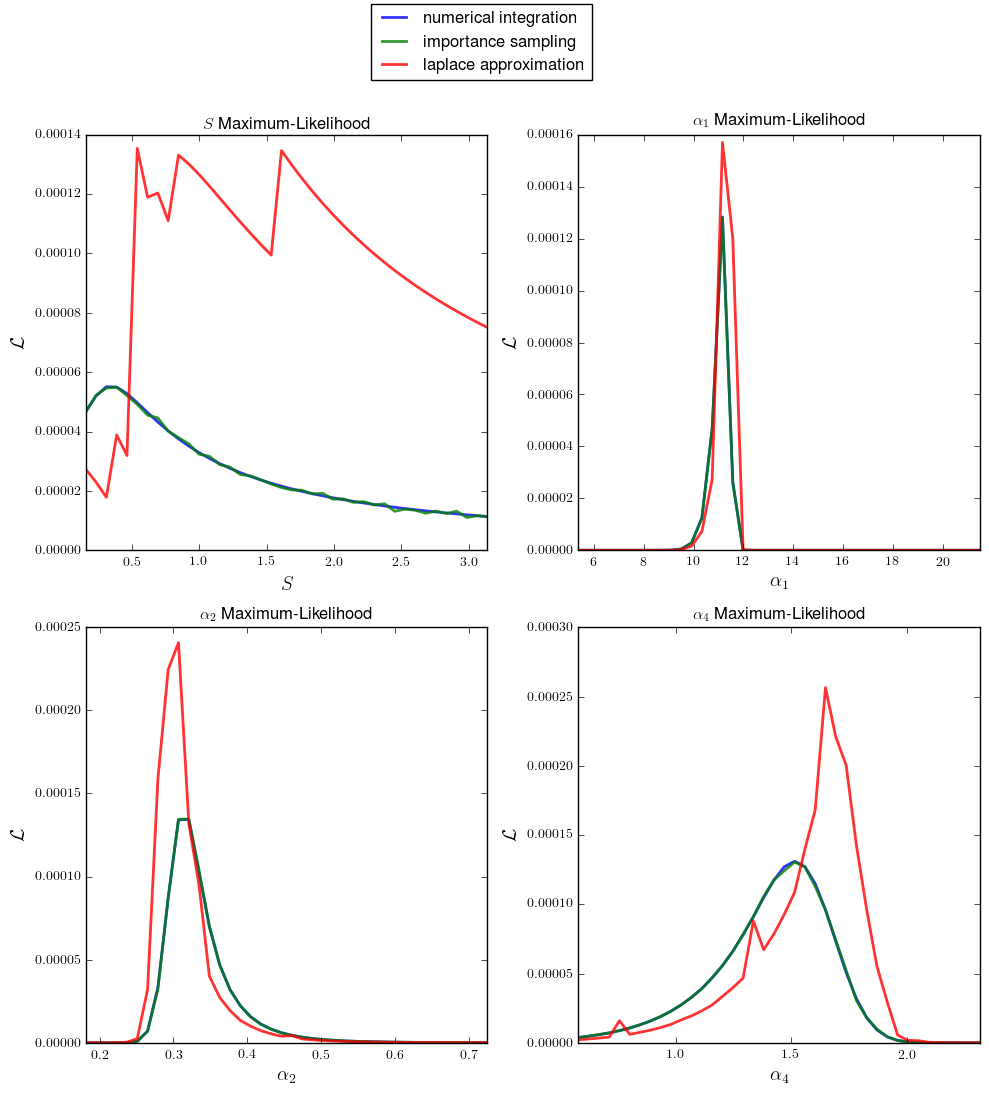

In [691]:
samps = 1
ticks = 40

plt.subplot(2,2,1)
space = S * np.linspace(1,20, ticks)
vals = np.zeros((len(space), samps))
ni = []
isi = []
la = []
for i,S_test in enumerate(space):
    ni.append(numerical_integration(a1,a2,a3,a4,S_test,nsamples=100))
    isi.append(importance_sampling_integration(a1,a2,a3,a4,S_test,nsamples=10**4))
    la.append(laplace_approximation(a1,a2,a3,a4,S_test))
plt.plot(space, ni, linewidth=2, alpha=0.8)
plt.plot(space, isi, alpha=0.8, linewidth=2)
plt.plot(space, la, alpha=0.8, linewidth=2)
plt.title(r'$S$ Maximum-Likelihood')
plt.xlabel(r'$S$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,2)
space = a1 * np.linspace(0.5,2, ticks)
vals = np.zeros((len(space), samps))
ni = []
isi = []
la = []
for i,test in enumerate(space):
    ni.append(numerical_integration(test,a2,a3,a4,S,nsamples=100))
    isi.append(importance_sampling_integration(test,a2,a3,a4,S,nsamples=10**4))
    la.append(laplace_approximation(test,a2,a3,a4,S))
plt.plot(space, ni, linewidth=2, alpha=0.8)
plt.plot(space, isi, alpha=0.8, linewidth=2)
plt.plot(space, la, alpha=0.8, linewidth=2)
plt.title(r'$\alpha_1$ Maximum-Likelihood')
plt.xlabel(r'$\alpha_1$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,3)
space = a2 * np.linspace(0.5,2, ticks)
vals = np.zeros((len(space), samps))
ni = []
isi = []
la = []
for i,test in enumerate(space):
    ni.append(numerical_integration(a1,test,a3,a4,S,nsamples=100))
    isi.append(importance_sampling_integration(a1,test,a3,a4,S,nsamples=10**4))
    la.append(laplace_approximation(a1,test,a3,a4,S))
plt.plot(space, ni, linewidth=2, alpha=0.8)
plt.plot(space, isi, alpha=0.8, linewidth=2)
plt.plot(space, la, alpha=0.8, linewidth=2)
plt.title(r'$\alpha_2$ Maximum-Likelihood')
plt.xlabel(r'$\alpha_2$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,4)
space = a4 * np.linspace(0.5,2, ticks)
vals = np.zeros((len(space), samps))
ni = []
isi = []
la = []
for i,test in enumerate(space):
    ni.append(numerical_integration(a1,a2,a3,test,S,nsamples=100))
    isi.append(importance_sampling_integration(a1,a2,a3,test,S,nsamples=10**4))
    la.append(laplace_approximation(a1,a2,a3,test,S))
l1, = plt.plot(space, ni, linewidth=2, alpha=0.8)
l2, = plt.plot(space, isi, alpha=0.8, linewidth=2)
l3, = plt.plot(space, la, alpha=0.8, linewidth=2)
plt.title(r'$\alpha_4$ Maximum-Likelihood')
plt.xlabel(r'$\alpha_4$', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.xlim([space.min(), space.max()])

plt.gcf().legend((l1,l2,l3), 
                 ('numerical integration','importance sampling',\
                'laplace approximation'),
                bbox_to_anchor=(0.6, 1.1))

plt.gcf().set_size_inches(10,10)
plt.tight_layout()

# Profiling

IS at $10^6$ samples, further broken up factors:

```
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    74                                           @profile
    75                                           def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    76         1            3      3.0      0.0      rev_S = 5.6578015811698101 * S
    77         1        89667  89667.0     12.0      lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    78         1        43605  43605.0      5.8      mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    79         1        80448  80448.0     10.8      masses = lognorm(rev_S, scale=mu_mass).rvs()
    80         1        37923  37923.0      5.1      pp1 = p1(true_lum_obs, lums, sigma)
    81         1       137928 137928.0     18.5      pp2 = p2(lums, masses, a1, a2, a3, a4, S, true_z)
    82         1       163074 163074.0     21.9      pp3 = p3(masses, true_z)
    83         1        46429  46429.0      6.2      qq1 = q1(lums, true_lum_obs, sigma)
    84         1       122534 122534.0     16.4      qq2 = q2(masses, lums, a1, a2, a3, a4, rev_S, true_z)
    85         1        24647  24647.0      3.3      integral = np.sum((pp1 * pp2 * pp3) / (qq1 * qq2)) / len(lums)
    86         1            4      4.0      0.0      return integral
```

IS and SMC at $10^3$ samples:

```
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    67                                           @profile
    68                                           def simple_monte_carlo_integration(a1, a2, a3, a4, S, nsamples=10**6):
    69         1          224    224.0      8.1      masses = prior.fetch(true_z).rvs(nsamples)
    70         1           54     54.0      2.0      mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    71         1         2414   2414.0     87.4      lums = lognorm(S, scale=mu_lum).rvs()
    72         1           70     70.0      2.5      return np.sum(p1(true_lum_obs, lums, sigma)) / (nsamples)

Total time: 0.003987 s
File: script.py
Function: importance_sampling_integration at line 74

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    74                                           @profile
    75                                           def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    76         1           14     14.0      0.4      rev_S = 5.6578015811698101 * S
    77         1         1818   1818.0     45.6      lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    78         1           48     48.0      1.2      mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    79         1         1624   1624.0     40.7      masses = lognorm(rev_S, scale=mu_mass).rvs()
    80         1            2      2.0      0.1      integral = np.sum((p1(true_lum_obs, lums, sigma) * \
    81         1          312    312.0      7.8              p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
    82         1          166    166.0      4.2                  (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
    83         1            2      2.0      0.1              len(lums)
    84         1            1      1.0      0.0      return integral
```

IS and SMC at $10^6$ samples:

```
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    67                                           @profile
    68                                           def simple_monte_carlo_integration(a1, a2, a3, a4, S, nsamples=10**6):
    69         1        78980  78980.0     31.2      masses = prior.fetch(true_z).rvs(nsamples)
    70         1        46124  46124.0     18.2      mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    71         1        83106  83106.0     32.8      lums = lognorm(S, scale=mu_lum).rvs()
    72         1        45011  45011.0     17.8      return np.sum(p1(true_lum_obs, lums, sigma)) / (nsamples)

Total time: 0.650202 s
File: script.py
Function: importance_sampling_integration at line 74

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    74                                           @profile
    75                                           def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    76         1            5      5.0      0.0      rev_S = 5.6578015811698101 * S
    77         1        65620  65620.0     10.1      lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    78         1        40388  40388.0      6.2      mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    79         1        72288  72288.0     11.1      masses = lognorm(rev_S, scale=mu_mass).rvs()
    80         1            4      4.0      0.0      integral = np.sum((p1(true_lum_obs, lums, sigma) * \
    81         1       316182 316182.0     48.6              p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
    82         1       155706 155706.0     23.9                  (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
    83         1            8      8.0      0.0              len(lums)
    84         1            1      1.0      0.0      return integral
```

Conclusions:
    - NI scales linearly ... duh
    - The conditional mass-luminosity and luminosity-mass and prior cost much more.
    - At extreme values the binary searches in prior implementation dominate
    - IS and SMC have three regions: flat to around 10**3 samples, linear until around 10**5 samples, nlogn from 10**5 samples and above.

In [584]:
n = 20
timevals = []
logspace = np.logspace(1, 7, n)
for i, nsamples in enumerate(logspace):
    nsamples = int(nsamples)
    start = time()
    importance_sampling_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time()
    timevals.append(end - start)

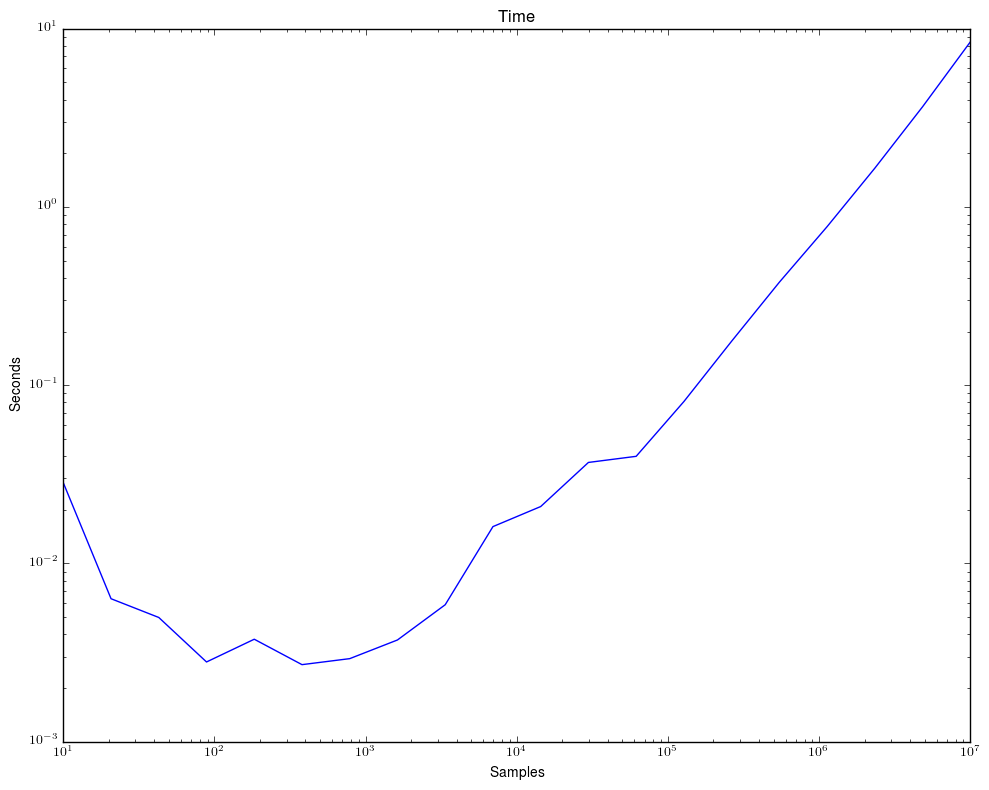

In [585]:
plt.plot(logspace, timevals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time')
plt.xlabel('Samples')
plt.ylabel('Seconds')

plt.gcf().set_size_inches(10,8)
plt.tight_layout();

In [593]:
len(prior.fetch(0).mass)

414

# Prior

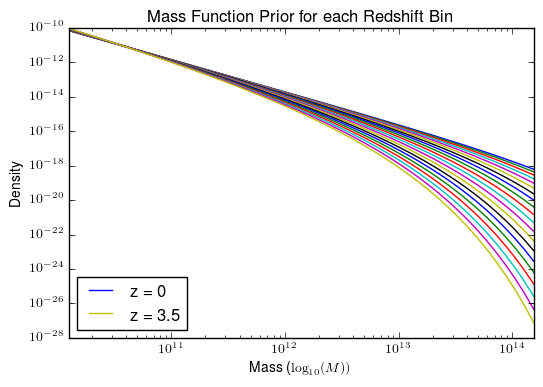

In [634]:
space = np.logspace(log10(prior.min_mass), log10(prior.max_mass))
for rs in prior.grid.redshifts:
    pdf = prior.fetch(rs).pdf(space)
    if rs == 0:
        plt.plot(space, pdf, label='z = 0')
    elif rs == 3.5:
        plt.plot(space, pdf, label='z = 3.5')
    else:
        plt.plot(space, pdf)
plt.legend(loc=3)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim([prior.min_mass, prior.max_mass])
plt.title('Mass Function Prior for each Redshift Bin')
plt.xlabel('Mass ($\log_{10}(M))$')
plt.ylabel('Density')

In [632]:
prior.grid.redshifts

array([ 0.        ,  0.18421053,  0.36842105,  0.55263158,  0.73684211,
        0.92105263,  1.10526316,  1.28947368,  1.47368421,  1.65789474,
        1.84210526,  2.02631579,  2.21052632,  2.39473684,  2.57894737,
        2.76315789,  2.94736842,  3.13157895,  3.31578947,  3.5       ])

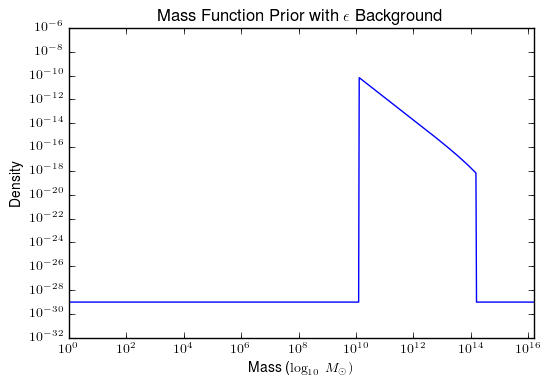

In [688]:
space = np.logspace(0, 20, 1000)
pdf = prior.fetch(0).pdf(space)
plt.plot(space, pdf)
plt.legend(loc=3)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.ylim([10**(-32), 10**(-6)])
plt.xlim([space.min(), 100* prior.max_mass])
plt.title('Mass Function Prior with $\epsilon$ Background')
plt.xlabel('Mass ($\log_{10}\ M_{\odot})$')
plt.ylabel('Density')

# Seed Choice

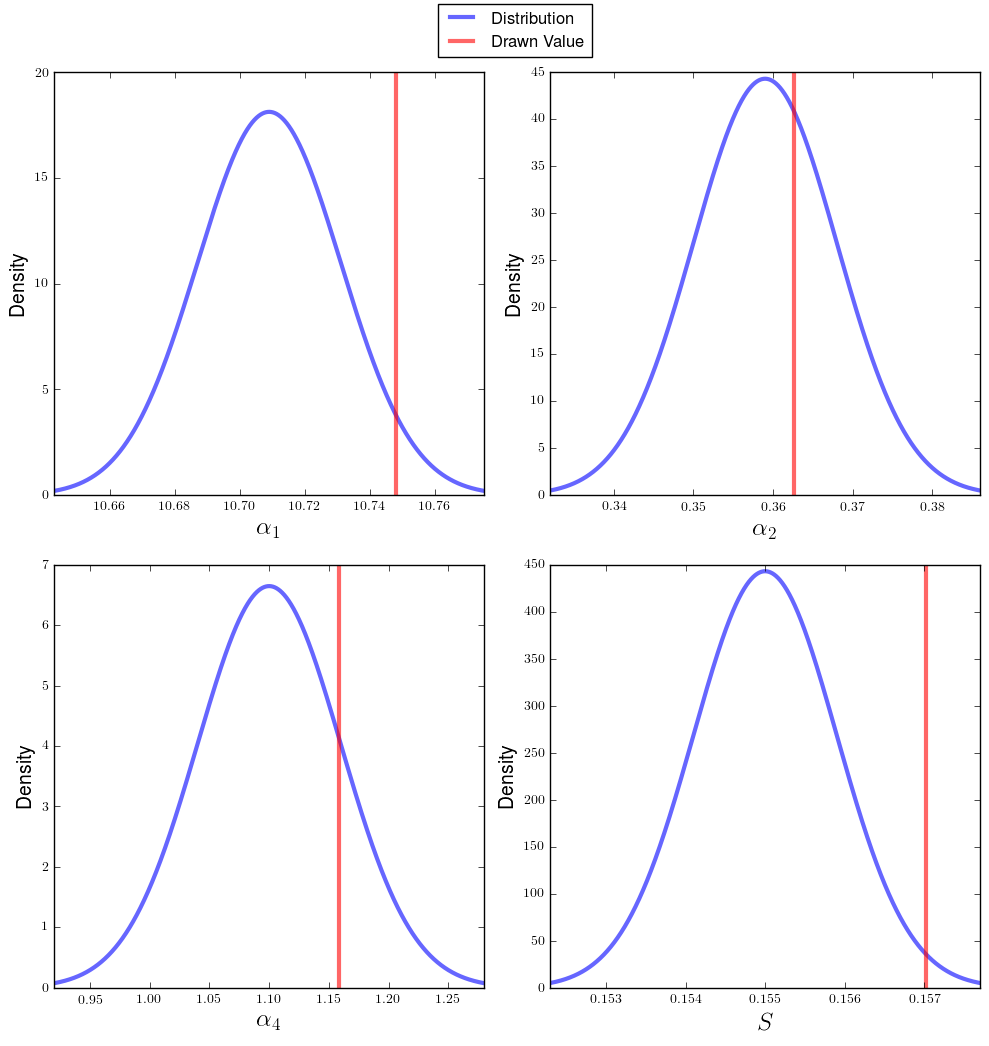

In [666]:
from scipy.stats import norm
samples = 10000
a1s = norm(10.709, 0.022).rvs(samples)
a2s = norm(0.359, 0.009).rvs(samples)
a4s = norm(1.10, 0.06).rvs(samples)
Ss = norm(0.155, 0.0009).rvs(samples)

plt.subplot(2,2,1)
space = np.linspace(10.709 - 3* 0.022, 10.709 + 3* 0.022, 10**4)
plt.plot(space, norm(10.709, 0.022).pdf(space), color='blue', linewidth=3, alpha=0.6)
plt.xlabel(r'$\alpha_1$', fontsize=18)
plt.ylabel(r'Density', fontsize=14)
plt.gca().axvline(a1, color='red', linewidth=3, alpha=0.6)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,2)
space = np.linspace(0.359 - 3* 0.009, 0.359 + 3* 0.009, 10**4)
plt.plot(space, norm(0.359, 0.009).pdf(space), color='blue', linewidth=3, alpha=0.6)
plt.xlabel(r'$\alpha_2$', fontsize=18)
plt.ylabel(r'Density', fontsize=14)
plt.gca().axvline(a2, color='red', linewidth=3, alpha=0.6)

plt.xlim([space.min(), space.max()])

plt.subplot(2,2,3)
space = np.linspace(1.10 - 3*0.06, 1.10 + 3*0.06, 10**4)
plt.plot(space, norm(1.10, 0.06).pdf(space), color='blue', linewidth=3, alpha=0.6)
plt.xlabel(r'$\alpha_4$', fontsize=18)
plt.ylabel(r'Density', fontsize=14)
plt.xlim([space.min(), space.max()])
plt.gca().axvline(a4, color='red', linewidth=3, alpha=0.6)

plt.subplot(2,2,4)
space = np.linspace(0.155 - 3*0.0009, 0.155 + 3*0.0009, 10**4)
l1, = plt.plot(space, norm(0.155, 0.0009).pdf(space), color='blue', linewidth=3, alpha=0.6)
plt.xlabel(r'$S$', fontsize=18)
plt.ylabel(r'Density', fontsize=14)
plt.xlim([space.min(), space.max()])
l2 = plt.gca().axvline(S, color='red', linewidth=3, alpha=0.6)

plt.gcf().legend((l1,l2), 
                 ('Distribution', 'Drawn Value'),
                bbox_to_anchor=(0.6, 1.05))
plt.gcf().set_size_inches(10,10)
plt.tight_layout()